In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tejatejaswinicr","key":"193ade1539f8fb146d17504d4d3faa37"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Unzip the dataset and remove the zip file
!unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [01:29<00:00, 100MB/s] 
100% 2.29G/2.29G [01:29<00:00, 27.6MB/s]
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: YES
  inflating: chest_xray/__MACOSX/._chest_xray  
replace chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
replace chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: chest_xray/__MACOSX/chest_xray/._test  
replace chest_xray/__MACOSX/chest_xray/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: chest_xray/__MACOSX/chest_xray/._train  
replace chest_xray/__MACOSX/chest_xray/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/__MACOSX/chest_xray/test/._NORMAL? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace chest_xray/_

In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install -q evaluate transformers datasets mlflow

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split


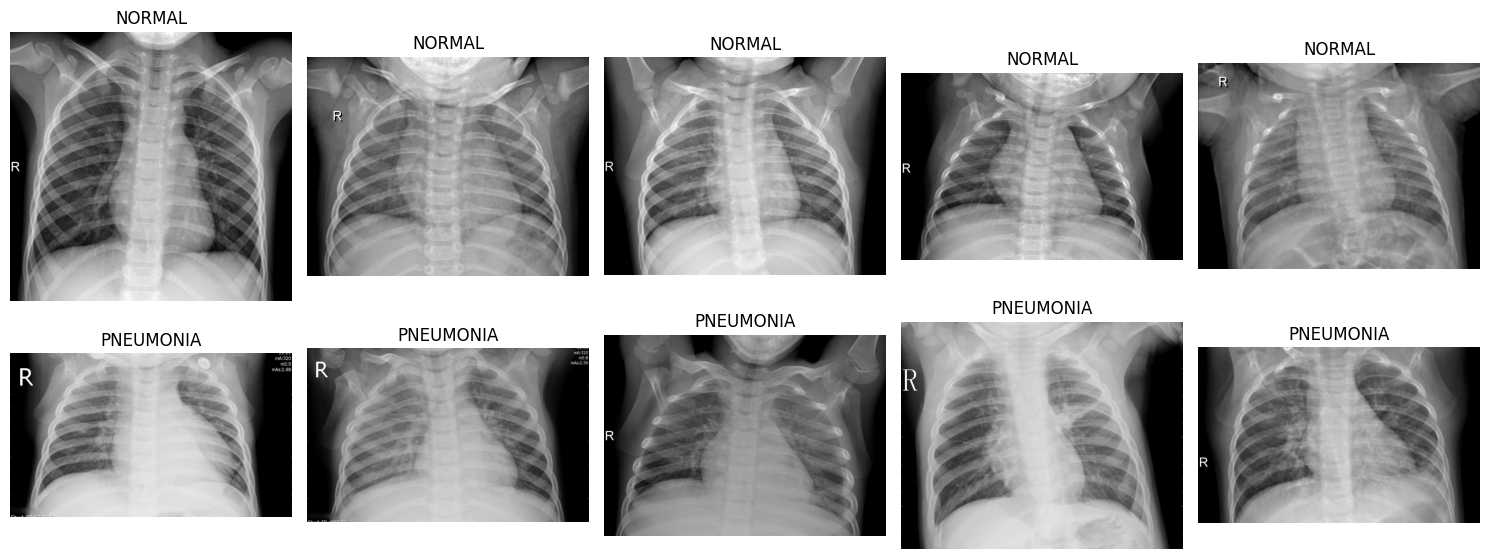

In [ ]:
# Directory paths
train_dir = Path("/content/chest_xray/train")
val_dir = Path("/content/chest_xray/val")
test_dir = Path("/content/chest_xray/test")

# Displaying a few images
def display_images(folder, num=5):
    pneumonia_imgs = list(folder.glob('PNEUMONIA/*.jpeg'))[:num]
    normal_imgs = list(folder.glob('NORMAL/*.jpeg'))[:num]

    fig, axes = plt.subplots(nrows=2, ncols=num, figsize=(15, 6))

    for i, img_path in enumerate(normal_imgs):
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("NORMAL")
        axes[0, i].axis('off')

    for i, img_path in enumerate(pneumonia_imgs):
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title("PNEUMONIA")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(train_dir)



In [ ]:
from torchvision import transforms

# Define transformations for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
label_mapping = {"NORMAL": 0, "PNEUMONIA": 1}


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Creating datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor

# Define the ViT configuration
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 2  # Normal and Pneumonia

# Load the pre-trained model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [ ]:
import torch
import torch.nn as nn

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []  # List to store training loss for each epoch
    val_accuracies = []  # List to store validation accuracy for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images).logits  # Get logits from model outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader.dataset)
        val_accuracy = 100 * correct / total

        # Append the computed values to their respective lists
        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_accuracies


In [ ]:
trained_model, train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)


Epoch 1/10, Loss: 0.2406, Validation Accuracy: 75.00%
Epoch 2/10, Loss: 0.0917, Validation Accuracy: 75.00%
Epoch 3/10, Loss: 0.0667, Validation Accuracy: 68.75%
Epoch 4/10, Loss: 0.0542, Validation Accuracy: 93.75%
Epoch 5/10, Loss: 0.0429, Validation Accuracy: 93.75%
Epoch 6/10, Loss: 0.0365, Validation Accuracy: 93.75%
Epoch 7/10, Loss: 0.0311, Validation Accuracy: 62.50%
Epoch 8/10, Loss: 0.0318, Validation Accuracy: 93.75%
Epoch 9/10, Loss: 0.0259, Validation Accuracy: 93.75%
Epoch 10/10, Loss: 0.0224, Validation Accuracy: 93.75%


In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

evaluate_model(trained_model, test_loader)


Test Accuracy: 81.09%


In [ ]:
# Save the model weights
torch.save(trained_model.state_dict(), "vit_chest_xray_model.pth")

# to load the model in the future
# model.load_state_dict(torch.load("vit_chest_xray_model.pth"))


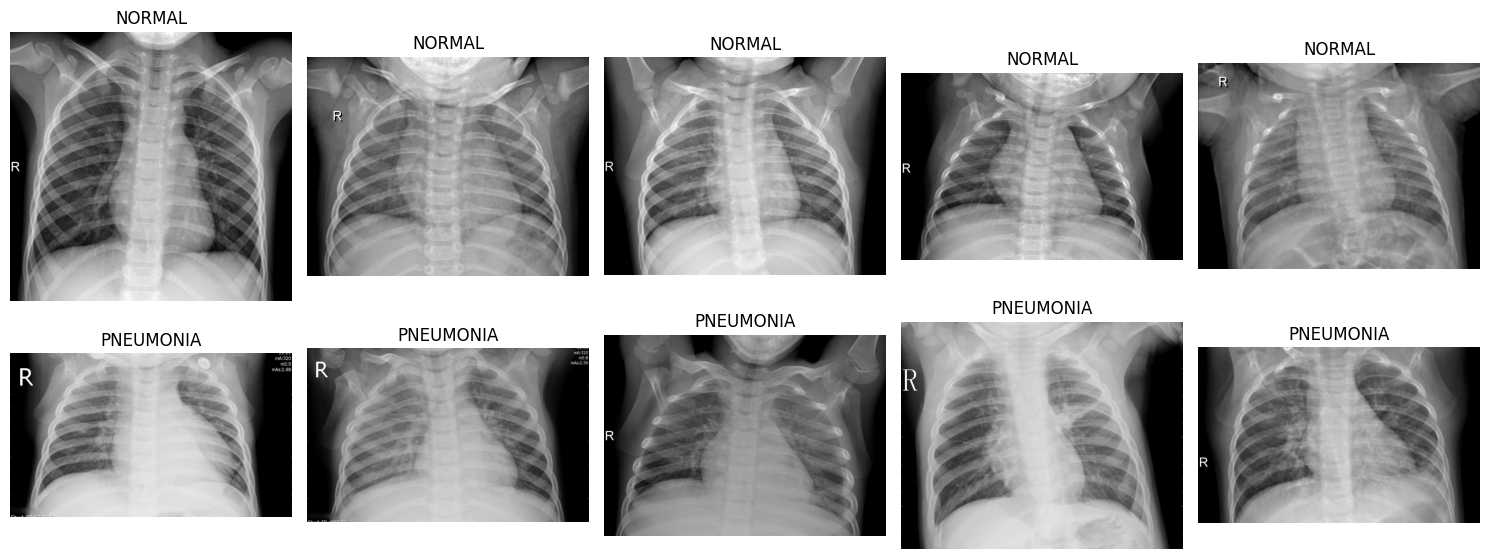

In [ ]:
display_images(train_dir)


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        # Training Phase
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_accuracies


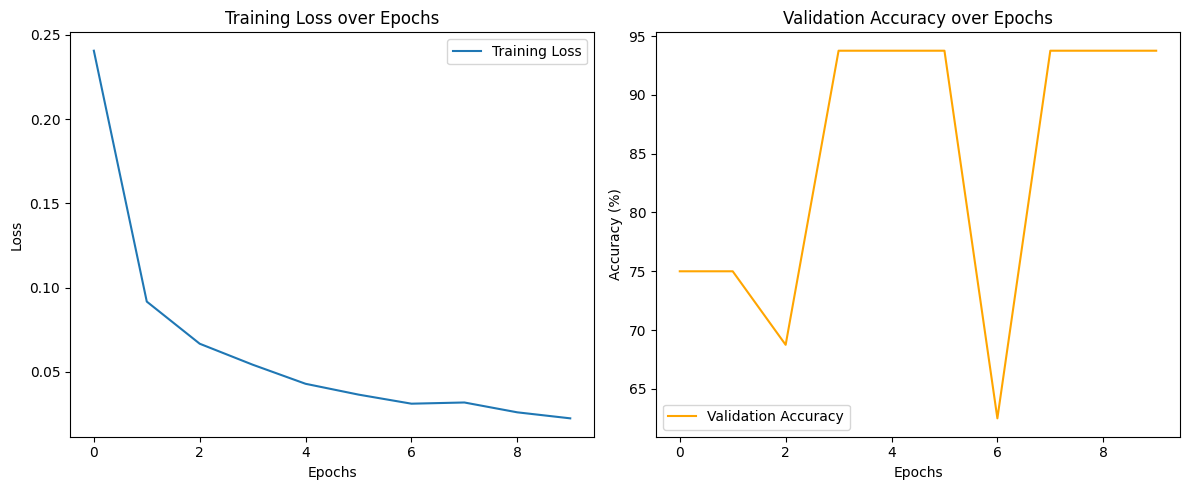

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


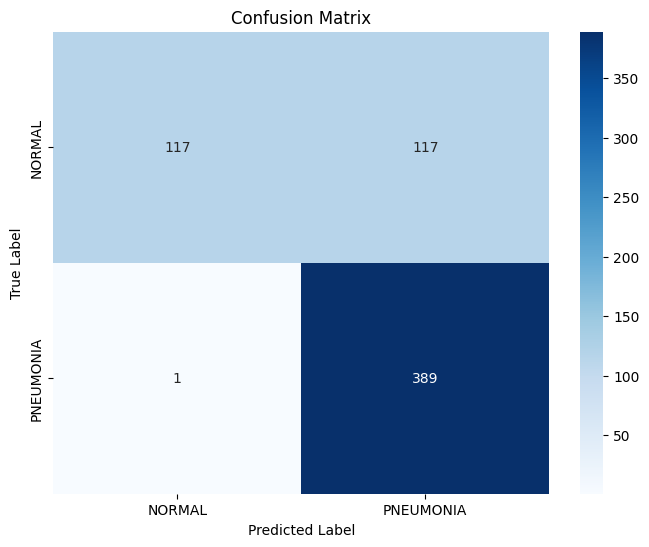

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Getting the true labels and the predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Now, we'll plot the confusion matrix
labels_list = ["NORMAL", "PNEUMONIA"]
plot_confusion_matrix(y_true, y_pred, labels_list)


FileUpload(value={}, accept='image/*', description='Upload')

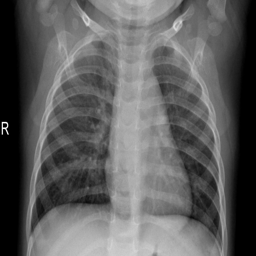

Prediction: Normal (77.29% confidence)


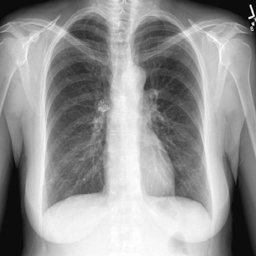

Prediction: Pneumonia (86.06% confidence)


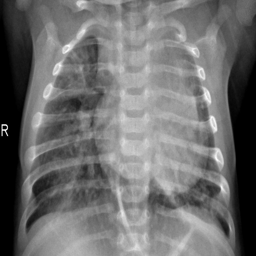

Prediction: Pneumonia (98.79% confidence)


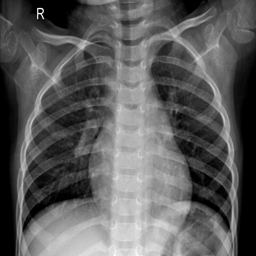

Prediction: Normal (81.60% confidence)


In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import ipywidgets as widgets
from IPython.display import display
import io
import torch.nn.functional as F

# --- Load the trained model (make sure you saved it earlier) ---
model.load_state_dict(torch.load("vit_chest_xray_model.pth", map_location=device))
model.eval()

# --- Define the same preprocessing used in training ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # adapt size if different during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # adjust if RGB/3-channel
])

# --- Function for prediction with confidence ---
def predict_image(image):
    image = image.convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, predicted = torch.max(probs, 1)

    classes = ["Normal", "Pneumonia"]
    return classes[predicted.item()], confidence.item() * 100

# --- File Upload Widget ---
uploader = widgets.FileUpload(
    accept='image/*',  # Accept image files
    multiple=False     # Only one image at a time
)

display(uploader)

def on_upload_change(change):
    for uploaded_filename in uploader.value:
        content = uploader.value[uploaded_filename]['content']
        image = Image.open(io.BytesIO(content))
        label, confidence = predict_image(image)
        display(image.resize((256, 256)))
        print(f"Prediction: {label} ({confidence:.2f}% confidence)")

uploader.observe(on_upload_change, names='value')
